# Hava Durumu Görüntü Sınıflandırma Projesi 
Bu projede hava durumunu ayırt etmesi için Convolutional Neural Network yani Evrişimsel Sinir Ağları oluşturacağız.
Bunun için Kaggle da bulunan 5-class weather status image classification veri setini kullanacağız.

# Kütüphaneleri İmport Edelim
Gerekli kütüphaneleri import edelim.

In [1]:
!pip install opencv-python

In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


2025-09-26 08:00:11.918928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758873612.290553      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758873612.401843      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Veri Seti Düzenleme
Veri setini düzenleyerek test,train ve validation bölümlerine ayıralım.

In [3]:
import os
import shutil
import random


original_dataset_dir = '/kaggle/input/5class-weather-status-image-classification/data'  

# Yeni dataset klasörü (train/validation/test olacak)
base_dir = '/kaggle/working/dataset_split'  
os.makedirs(base_dir, exist_ok=True)

# Train/Validation/Test klasörlerini oluştur
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)

    for class_name in os.listdir(original_dataset_dir):
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)

        class_dir = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_dir)
        random.shuffle(images)

        # %70 train, %20 validation, %10 test
        train_split = int(0.7 * len(images))
        val_split = int(0.9 * len(images))

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        # Dosyaları kopyala
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_dir, class_name, img))

print("Dataset train/validation/test olarak ayrıldı!")



Dataset train/validation/test olarak ayrıldı!


# Veri Seti İşleme ve Görselleştirme
Veri setini 0-1 arasına çekelim.Sınıfları isimlendirelim ve görsel oluşturalım.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import numpy as np 

# 1. ImageDataGenerator Tanımlamaları 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           
    width_shift_range=0.25,      
    height_shift_range=0.25,     
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

#  2. Data Generator Akışları
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

print(f"\nEğitim verisi: {train_generator.n} resim")
print(f"Doğrulama verisi: {validation_generator.n} resim")
print(f"Test verisi: {test_generator.n} resim")

Found 18038 images belonging to 5 classes.
Found 18038 images belonging to 5 classes.
Found 18038 images belonging to 5 classes.

Eğitim verisi: 18038 resim
Doğrulama verisi: 18038 resim
Test verisi: 18038 resim


# Sinir Ağının Oluşturulması
Modelimizin nesnesi oluşturmak için tf.keras.Sequential() kullanacağız.
Katmanları oluşturacağız.(Conv2D (Konvolüsyon Katmanı),MaxPooling2D (Havuzlama Katmanı),Flatten,Dense (Tam Bağlantılı Katman),Dropout)

In [5]:
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau # Dinamik hız kontrolü için eklendi

inputs = Input(shape=(64, 64, 3))

# BLOK 1
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs) 
x = layers.MaxPooling2D(2,2)(x)


# BLOK 2
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x) 
x = layers.MaxPooling2D(2,2)(x)
x = layers.Dropout(0.25)(x) 

# BLOK 3
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x) 
x = layers.MaxPooling2D(2,2)(x)
x = layers.Dropout(0.25)(x)

# BLOK 4
x = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x) 
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)

# TAM BAĞLANTILI KATMANLAR
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x) 

outputs = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Öğrenme hızı 0.0005 olarak ayarlandı
optimizer = Adam(learning_rate=0.0005) 

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


I0000 00:00:1758873955.630229      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758873955.630885      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Modeli Eğitme
Modeli model.fit() ile eğiteceğiz ve model.save ile kaydedeceğiz.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks tanımlamaları
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10) 

# Eğitimi başlat
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100, # Veya daha fazla
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr] 
)
model.save('final_best_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1758873961.137792      89 service.cc:148] XLA service 0x79f3cc00fd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758873961.139394      89 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758873961.139418      89 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758873961.586574      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/140 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.2188 - loss: 1.5770  

I0000 00:00:1758873969.676378      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 467ms/step - accuracy: 0.4666 - loss: 1.2641 - val_accuracy: 0.6453 - val_loss: 0.9016 - learning_rate: 5.0000e-04
Epoch 2/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.7266 - loss: 0.7842

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.7266 - loss: 0.7842 - val_accuracy: 0.6461 - val_loss: 0.8952 - learning_rate: 5.0000e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 58s 413ms/step - accuracy: 0.6420 - loss: 0.9205 - val_accuracy: 0.6929 - val_loss: 0.8075 - learning_rate: 5.0000e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.7109 - loss: 0.7437 - val_accuracy: 0.6931 - val_loss: 0.8088 - learning_rate: 5.0000e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 57s 405ms/step - accuracy: 0.6669 - loss: 0.8667 - val_accuracy: 0.7024 - val_loss: 0.7574 - learning_rate: 5.0000e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.6719 - loss: 0.8215 - val_accuracy: 0.7040 - val_loss: 0.7542 - learning_rate: 5.0000e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 57s 405ms/step - accuracy: 0.6818 - loss: 0.8265 - val_accuracy: 0.7134 - val_loss: 0.7661 - learning_rate: 5.0000e-04
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/s

# Eğitim Sonuçlarını Görselleştirme Ve Doğruluk Payı
Eğitim sonuçlarını grafik ile görselleştirelim ve doğruluk payını hesaplayalım.

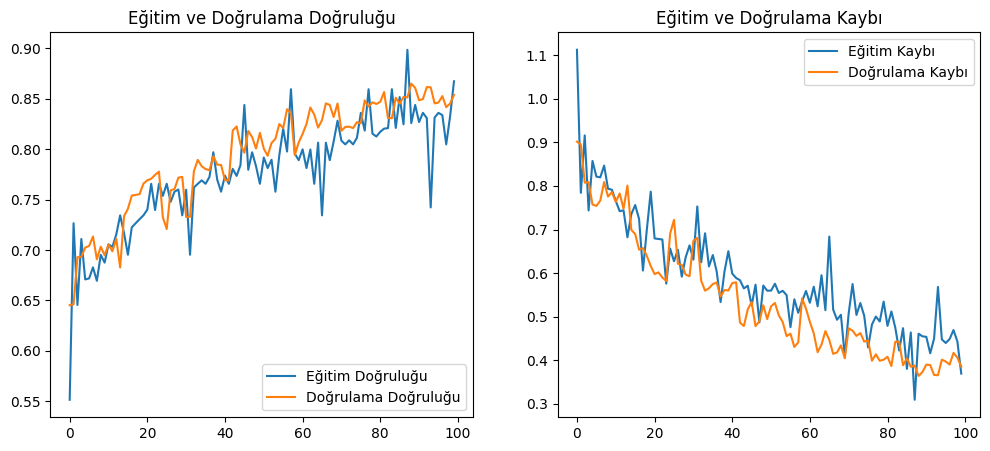

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')

plt.show()


# Performans Değerlendirmesi
Modelin performansını değerlendirelim.

In [8]:
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=2
)

print(f"Test kaybı: {test_loss:.4f}")
print(f"Test doğruluk: {test_acc*100:.2f}%")


141/141 - 20s - 142ms/step - accuracy: 0.8653 - loss: 0.3630
Test kaybı: 0.3630
Test doğruluk: 86.53%


# Tahmin Denemesi
Model nesnesinde .prediction() metodunu kullanarak deneme yapalım.

In [9]:

sample_batch, _ = next(test_generator)
sample_image = sample_batch[0:1]  

# Tahmin yap
pred = model.predict(sample_image)  # output: [[0.1, 0.2, 0.05, 0.6, 0.05]]

# Tahmin edilen sınıf
predicted_class_index = np.argmax(pred, axis=1)[0]

# Tahmin olasılığı
predicted_prob = np.max(pred)

# Sınıf isimleri
class_names = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
predicted_class_name = class_names[predicted_class_index]

print(f"Modelin tahmini sınıfı: {predicted_class_name}")
print(f"Tahmin olasılığı: {predicted_prob*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
Modelin tahmini sınıfı: cloudy
Tahmin olasılığı: 57.94%


# Grad-CAM ile Model Yorumlanabilirliği

✅ Model, kaydedilen ağırlıklarla başarıyla yüklendi.
Grad-CAM için kullanılacak katman: conv2d_3

--- Grad-CAM ile Model Yorumlanabilirliği (Rastgele Tahminler) ---

--- Batch 1 İşleniyor ---


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


------------------------------
Görüntü 1 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


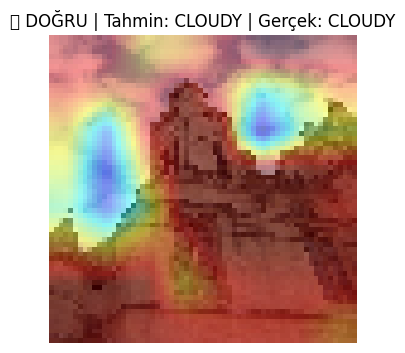

------------------------------
Görüntü 2 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


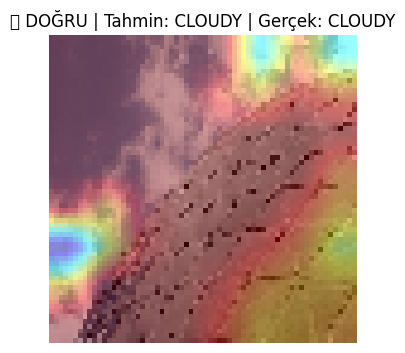

------------------------------
Görüntü 3 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


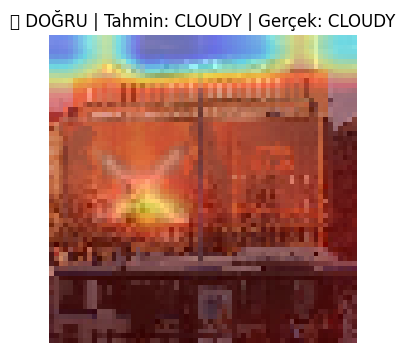


--- Batch 2 İşleniyor ---
------------------------------
Görüntü 1 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


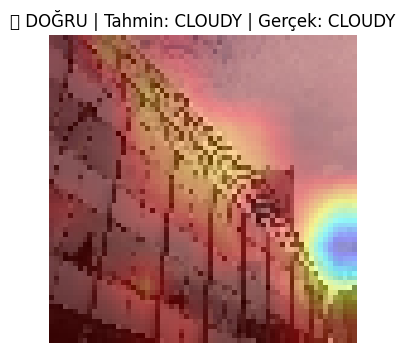

------------------------------
Görüntü 2 | Gerçek: cloudy, Tahmin: rainy (❌ YANLIŞ)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


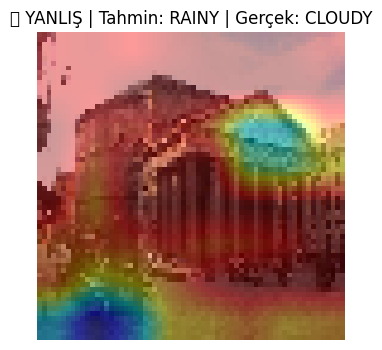

------------------------------
Görüntü 3 | Gerçek: cloudy, Tahmin: snowy (❌ YANLIŞ)


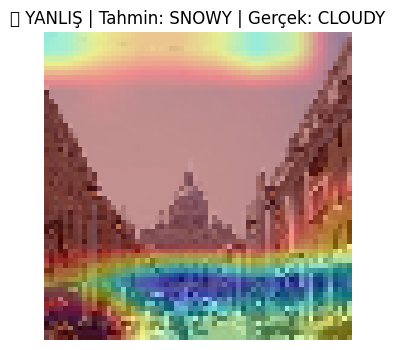


--- Batch 3 İşleniyor ---
------------------------------
Görüntü 1 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


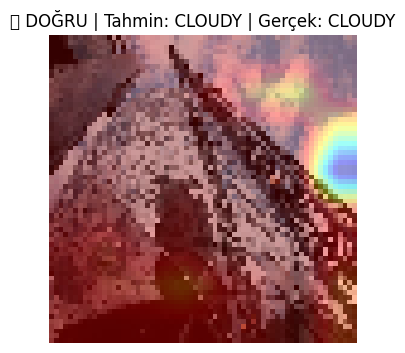

------------------------------
Görüntü 2 | Gerçek: cloudy, Tahmin: sunny (❌ YANLIŞ)


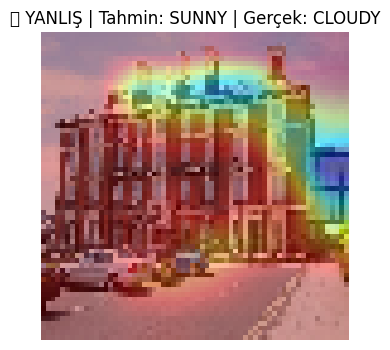

------------------------------
Görüntü 3 | Gerçek: cloudy, Tahmin: rainy (❌ YANLIŞ)


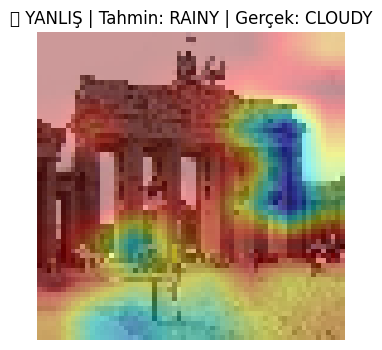


--- Batch 4 İşleniyor ---
------------------------------
Görüntü 1 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


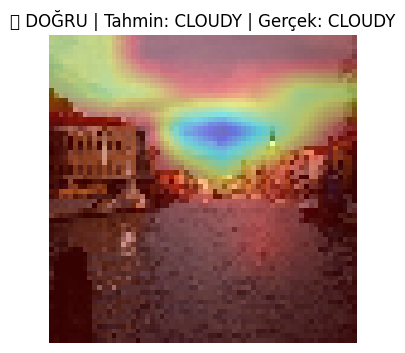

------------------------------
Görüntü 2 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


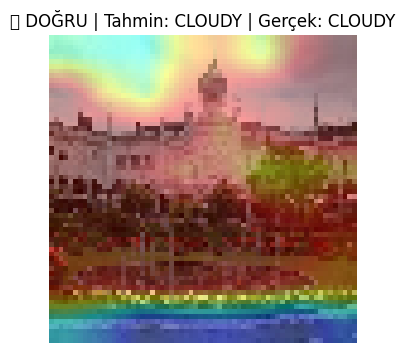

------------------------------
Görüntü 3 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


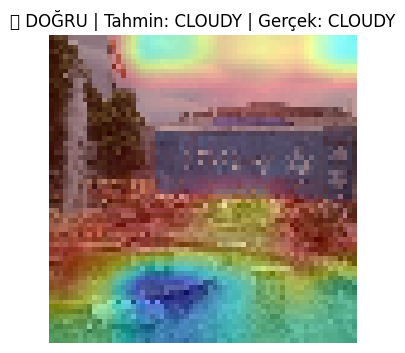


--- Batch 5 İşleniyor ---
------------------------------
Görüntü 1 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


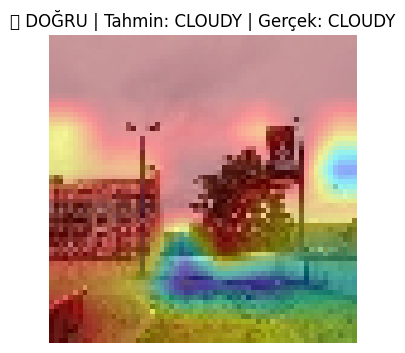

------------------------------
Görüntü 2 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


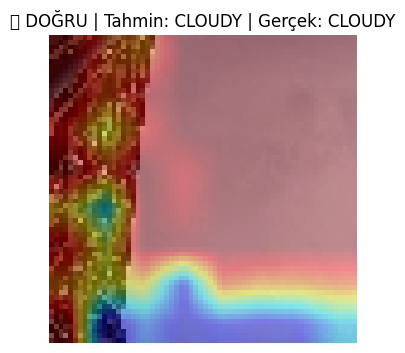

------------------------------
Görüntü 3 | Gerçek: cloudy, Tahmin: cloudy (✅ DOĞRU)


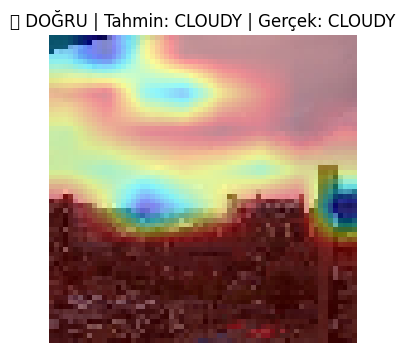

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 

try:
    # Model, eğitimden sonra kaydedilen dosyadan yükleniyor.
    model = tf.keras.models.load_model('final_best_model.h5')
    # Son katman adını model yüklendikten sonra alıyoruz
    LAST_CONV_LAYER_NAME = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            LAST_CONV_LAYER_NAME = layer.name
            break
    print("✅ Model, kaydedilen ağırlıklarla başarıyla yüklendi.")
    print("Grad-CAM için kullanılacak katman:", LAST_CONV_LAYER_NAME)

except Exception as e:
    # Yükleme başarısız olursa, Grad-CAM çalışmaz.
    print("❌ Kayıtlı model yüklenemedi. Lütfen önce 'Run All' ile modeli eğitin ve kaydedin.")
    print(f"Hata: {e}")
    # Eğer yüklenemezse, kodun geri kalanının çalışmasını durdururuz
    raise SystemExit(0) 

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    grad_model = Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Heatmap Görselleştirme 

def display_gradcam(img_array, heatmap, title="Grad-CAM"):
    img = np.uint8(255 * img_array) if img_array.max() <= 1 else np.uint8(img_array)
    heatmap = cv2.resize(heatmap, (int(img.shape[1]), int(img.shape[0])), interpolation=cv2.INTER_LINEAR)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    # Görseli göster
    plt.figure(figsize=(6, 4))
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


CLASS_NAMES = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']


# Grad-CAM Uygulaması (Rastgele 15 Tahmin)

print("\n--- Grad-CAM ile Model Yorumlanabilirliği (Rastgele Tahminler) ---")

iterator = iter(test_generator) 


for batch_num in range(5): 
    try:
        images, labels = next(iterator)
    except StopIteration:
        break

    print(f"\n--- Batch {batch_num + 1} İşleniyor ---")
    
    for i in range(min(len(images), 3)): 
        img_array = images[i]
        true_index = tf.argmax(labels[i]).numpy()
        true_label = CLASS_NAMES[true_index]
        
        img_for_pred = tf.expand_dims(img_array, axis=0)
        img_for_pred = tf.convert_to_tensor(img_for_pred, dtype=tf.float32)
        
        # Tahmin 
        predictions = model.predict(img_for_pred, verbose=0)
        predicted_index = np.argmax(predictions[0])
        predicted_label = CLASS_NAMES[predicted_index]

        # Grad-CAM'i çalıştır 
        heatmap = make_gradcam_heatmap(
            img_for_pred, model, LAST_CONV_LAYER_NAME, pred_index=predicted_index
        )
        
        
        if predicted_index == true_index:
            result_status = "✅ DOĞRU"
        else:
            result_status = "❌ YANLIŞ"

        title = f"{result_status} | Tahmin: {predicted_label.upper()} | Gerçek: {true_label.upper()}"
        
        print("-" * 30)
        print(f"Görüntü {i+1} | Gerçek: {true_label}, Tahmin: {predicted_label} ({result_status})")
        display_gradcam(img_array, heatmap, title)